# Proyek Akhir : Image Classification Model Deployment
- Nama: Ananta Alfallah Tarigan
- Email: anantar437471@gmail.com
- Id Dicoding: ananta_alfallah
- Dataset: https://drive.google.com/drive/folders/1UxOLf-h-QNhwWL-q1Z1KgSUhBUsuFfTz?usp=sharing (memiliki resolusi gambar tidak seragam)

In [25]:
from google.colab import drive
import tensorflow as tf
!pip install split-folders
import zipfile, splitfolders, os, random, shutil
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import pathlib
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
local_zip = '/content/drive/MyDrive/Project3/data_fix.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/drive/MyDrive/Project3/')

zip_ref.close()

base_dir = '/content/drive/MyDrive/Project3/data_fix'
os.listdir('/content/drive/MyDrive/Project3/data_fix')

['chicken', 'dog', 'horse', 'spider']

Melakukan undersampling agar sample di tiap kelas berjumlah sama


In [3]:
base_dir = '/content/drive/MyDrive/Project3/data_fix'
undersampled_dir = os.path.join(base_dir, 'undersampled')
os.makedirs(undersampled_dir, exist_ok=True)

undersample_folders = ['dog', 'spider', 'chicken', 'horse']
min_count = len(os.listdir('/content/drive/MyDrive/Project3/data_fix/horse'))

for folder in undersample_folders:
    folder_path = os.path.join(base_dir, folder)
    files = os.listdir(folder_path)
    files_to_keep = random.sample(files, min_count)
    target_dir = os.path.join(undersampled_dir, folder)
    os.makedirs(target_dir, exist_ok=True)
    for file in files_to_keep:
        source_file = os.path.join(folder_path, file)
        target_file = os.path.join(target_dir, file)
        shutil.copyfile(source_file, target_file)

print(os.listdir(undersampled_dir))

['dog', 'spider', 'chicken', 'horse']


In [23]:
print('chicken samples count:', len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/chicken')))
print('dog samples count:', len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/dog')))
print('horse samples count:', len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/horse')))
print('spider samples count:', len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/spider')))
print('total sample dalam dataset:', (len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/chicken'))+len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/dog'))+len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/horse'))+len(os.listdir('/content/drive/MyDrive/Project3/data_fix/undersampled/spider'))))

chicken samples count: 2623
dog samples count: 2623
horse samples count: 2623
spider samples count: 2623
total sample dalam dataset: 10492


Melakukan library splitfolders untuk memisahkan train set dan validation set, dengan ratio (80% dan 20%)

In [8]:
splitfolders.ratio('/content/drive/MyDrive/Project3/data_fix/undersampled', output="output", seed=1337, ratio=(0.8, 0.2))


Copying files: 10492 files [00:30, 339.31 files/s]


In [9]:
os.listdir('output')

['train', 'val']

In [10]:
os.listdir('output/train')

['chicken', 'spider', 'dog', 'horse']

In [11]:
os.listdir('output/val')

['chicken', 'spider', 'dog', 'horse']

In [12]:
train_dir = 'output/train'
val_dir = 'output/val'

In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
validation_datagen = ImageDataGenerator(
                    rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

Found 8392 images belonging to 4 classes.
Found 2100 images belonging to 4 classes.


In [18]:
model = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.layers[0].trainable = False

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.compile(optimizer=tf.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
              epochs=100,
              validation_data=validation_generator, callbacks = [early_stopping])

Epoch 1/100
263/263 [==============================] - 76s 253ms/step - loss: 0.4296 - accuracy: 0.8762 - val_loss: 0.1958 - val_accuracy: 0.9448
Epoch 2/100
263/263 [==============================] - 63s 241ms/step - loss: 0.2477 - accuracy: 0.9192 - val_loss: 0.1224 - val_accuracy: 0.9619
Epoch 3/100
263/263 [==============================] - 63s 240ms/step - loss: 0.2125 - accuracy: 0.9327 - val_loss: 0.1465 - val_accuracy: 0.9519
Epoch 4/100
263/263 [==============================] - 63s 241ms/step - loss: 0.1901 - accuracy: 0.9396 - val_loss: 0.1349 - val_accuracy: 0.9567
Epoch 5/100
263/263 [==============================] - 66s 250ms/step - loss: 0.1873 - accuracy: 0.9382 - val_loss: 0.1608 - val_accuracy: 0.9567
Epoch 6/100
263/263 [==============================] - 63s 240ms/step - loss: 0.1659 - accuracy: 0.9458 - val_loss: 0.1283 - val_accuracy: 0.9652


Akurasi pada training set dan validation set >92%

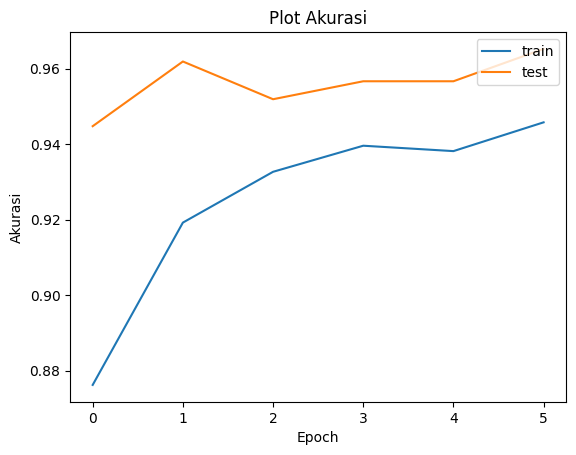

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot Akurasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

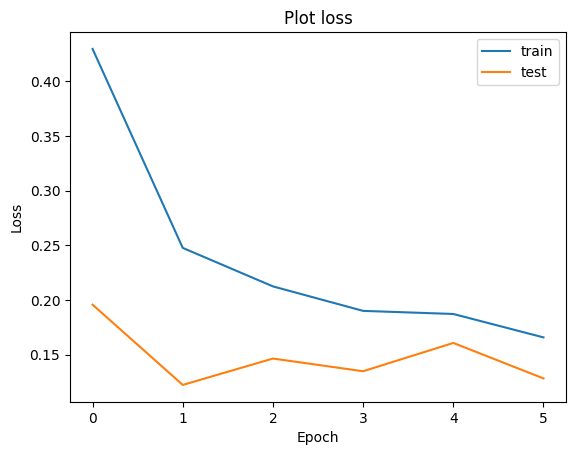

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Menulis kode untuk menyimpan model ke dalam format TF-Lite

In [27]:
export_dir = '/content/drive/MyDrive/Project3/saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/content/drive/MyDrive/Project3/animals.tflite')
tflite_model_file.write_bytes(tflite_model)

11852920